# 日历效应策略

一个特别简单的投资策略，策略：每个月的前五个交易日满仓沪深 300 指数，其他日子都空仓。

关于这个策略的可能的逻辑猜想（月末银行和散户资金流吃紧，月初流动性增强）：
- 国内银行每个月月底会归拢资金或者核账，所以导致月底钱比较紧，但下个月初又会把钱放出来，这就形成月初的资金流动性比平时好；
- 大多数人每月底领到工资，月初就可以定投出去了。可能是因为这两个因素，形成了一个有规律的月初买入资金流。
>对于这两点假设，无法通过回测来完全证实。

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# %run ./shared/tools.py

from shared.tools import get_drawdown, cal_period_perf_indicator, datestr2dtdate, date_count_in_month


策略逻辑

In [3]:
def calendar_strategy(index_data, index_id, start_date, end_date, calendard_range, fee_rate):
    df = index_data.loc[start_date:end_date, [index_id]]
    df['index_ret'] = df[index_id].pct_change()
    # 设置仓位
    df['date_count_in_month'] = date_count_in_month(df.index)
    df['pos'] = [1 if (e >= calendard_range[0] and e <= calendard_range[1]) else 0 for e in df['date_count_in_month']]
    # df['pos']= df.pos.shift(-1, fill_value=0)

    df['stgy_ret'] = df['pos'] * df['index_ret']
    rebalancing_rows = df[df['date_count_in_month'] == 1].index
    df.loc[rebalancing_rows, 'stgy_ret'] = df.loc[rebalancing_rows, 'stgy_ret'] - fee_rate
    df['stgy'] = (1 + df['stgy_ret']).cumprod().fillna(1)
    df['index'] = (1 + df['index_ret']).cumprod().fillna(1)
    # df.fillna({'index': 1, 'stgy': 1}, inplace=True)

    # 回测结果展示
    fig = plt.figure(figsize=(16, 8))

    ret_df = df.loc[:, ['index', 'stgy']]
    ax1 = fig.add_subplot(2, 1, 1)
    ret_df.plot(ax=ax1,
                grid=True,
                title='%s: t1=%d, t2=%d' % (index_id, calendard_range[0], calendard_range[1]),
                legend=True)

    ax2 = fig.add_subplot(2, 1, 2)
    df.loc[:, ['pos']].plot(ax=ax2, grid=True)

    res = cal_period_perf_indicator(ret_df)
    res['TotalRet'] = ret_df.iloc[-1] - 1
    print(res)


def load_hist_data(symbol_id, col_mappings, folder='../res'):
    index_data = pd.read_csv(f'{folder}/{symbol_id}.csv').set_index('datetime')
    index_data.index = [datestr2dtdate(e) for e in index_data.index]
    if col_mappings:
        index_data.rename(columns=col_mappings, inplace=True)
    return index_data

设置回测参数

In [4]:
# 回测起止日期
start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2022, 12, 31)
# 每月持仓交易起始日、截止日。从1起
day_range = [1,5]
# 交易手续费
fee_rate_fund = 0.0015
fee_rate_stock = 0.00025

加载回测数据

In [5]:
index_data = pd.read_csv('../res/指数历史数据.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

index_ids = ['hs300', 'csi500', 'csi1000']

回测

读懂回测结果：

- AnnRet 表示年化收益，AnnVol 表示年化波动率，SR 表示夏普率，MaxDD 表示最大回撤，Calmar 表示年化收益与最大回撤的比值；
- 蓝色线 asset 代表投资标的，橙色线 stgy 代表策略，pos 代表仓位。

沪深 300

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index -0.016334  0.203249 -0.080364 -0.395856 -0.041262 -0.047688
stgy   0.142632   0.11104  1.284515 -0.121568  1.173274  0.485269


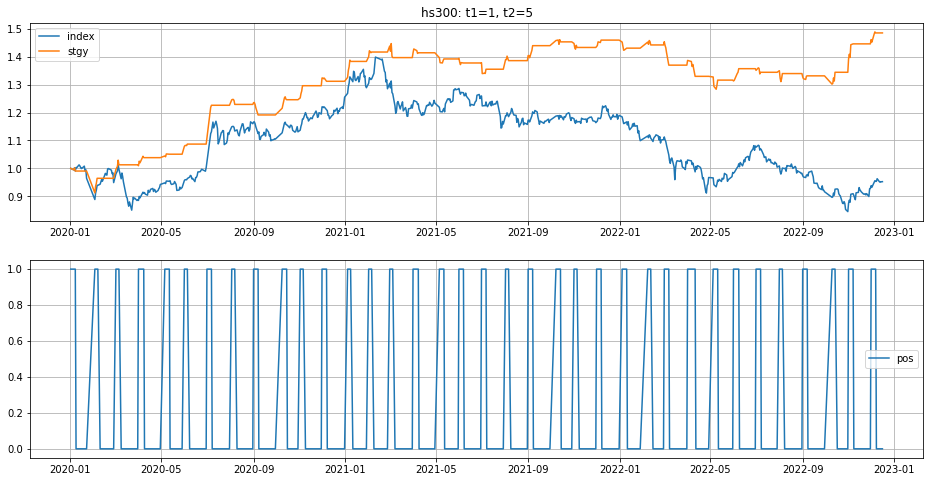

In [6]:
# 标的指数：'hs300' or 'csi500' or 'csi1000'

calendar_strategy(index_data, index_ids[0], start_date, end_date, day_range, fee_rate_stock)


中证 500

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.042582  0.210388  0.202395 -0.315704  0.134878  0.131701
stgy   0.177352  0.109059  1.626196 -0.106446  1.666128  0.623211


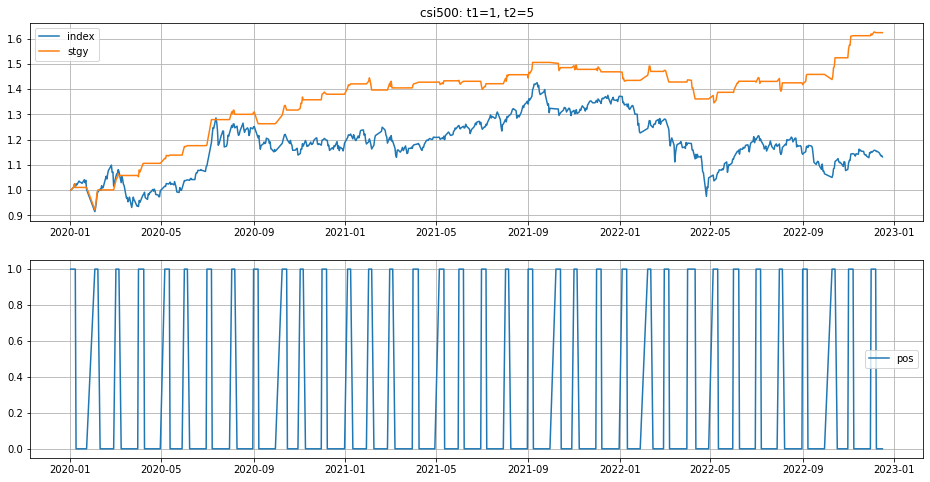

In [7]:
calendar_strategy(index_data, index_ids[1], start_date, end_date, day_range, fee_rate_stock)

中证 1000

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.047768  0.237842  0.200839 -0.346243  0.137961  0.148485
stgy   0.167123  0.121816  1.371925 -0.171917  0.972111  0.581724


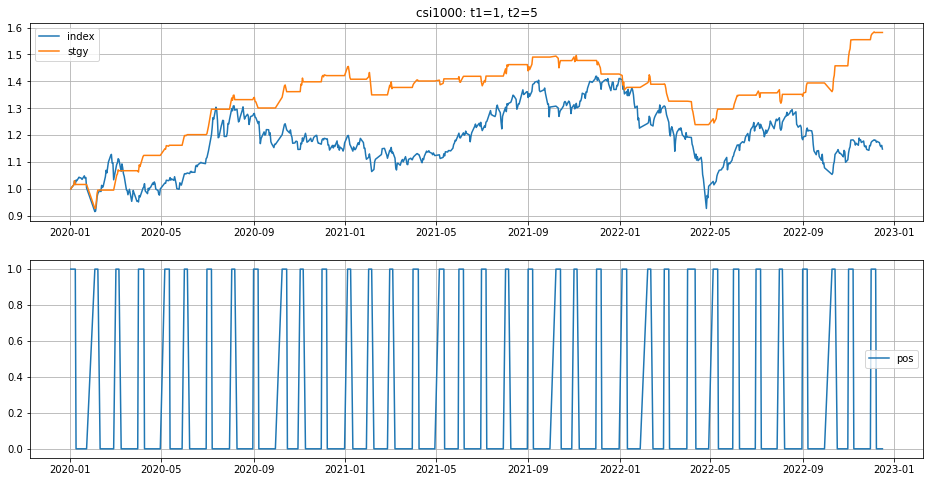

In [8]:
calendar_strategy(index_data, index_ids[2], start_date, end_date, day_range, fee_rate_stock)

## 中证 500 替代方案

### 基金替代指数

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.060683  0.188977  0.321112 -0.287292  0.211224  0.190997
stgy   0.144641  0.097399  1.485043 -0.104109  1.389329  0.493030


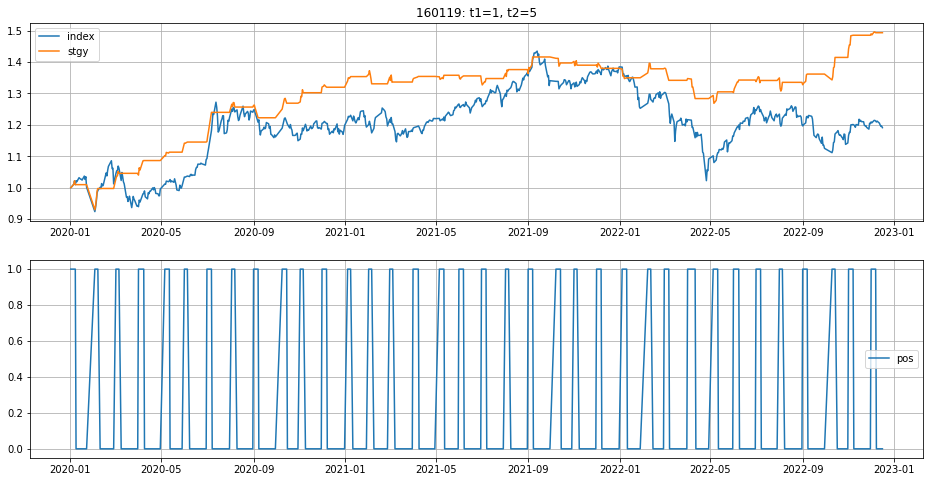

In [9]:
# 161017 (富国500), 160119 (南方500)
symbol_id = '160119'

index_data = load_hist_data(symbol_id, col_mappings={'nav': symbol_id}, folder='../res/500')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_fund)

### ETF 替代指数

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.063598   0.21032  0.302388 -0.315079  0.201848  0.200736
stgy   0.182206  0.109531  1.663501 -0.105243  1.731287  0.643145


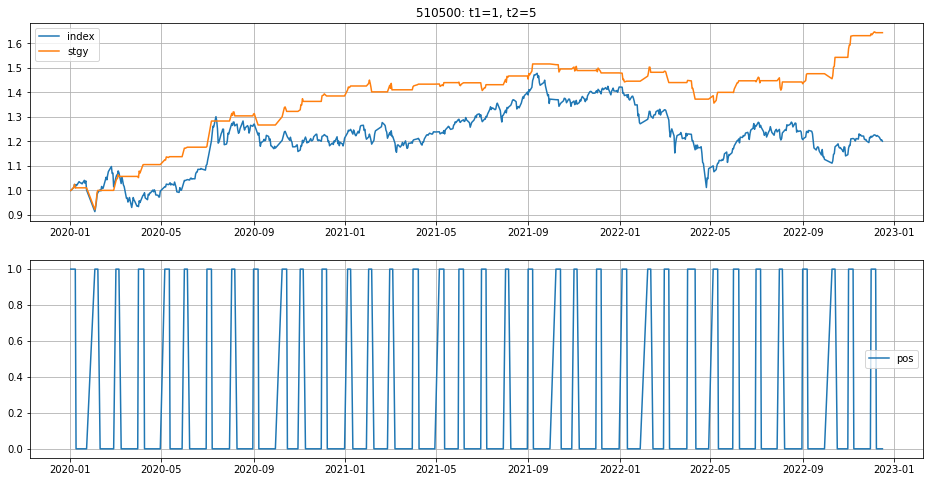

In [10]:
symbol_id = '510500'

index_data = load_hist_data(symbol_id, col_mappings={'close': symbol_id}, folder='../res/500')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

### 中证500质量

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.043136  0.208972  0.206418 -0.286015  0.150816  0.134079
stgy   0.178864  0.107343  1.666276 -0.094267  1.897412  0.632730


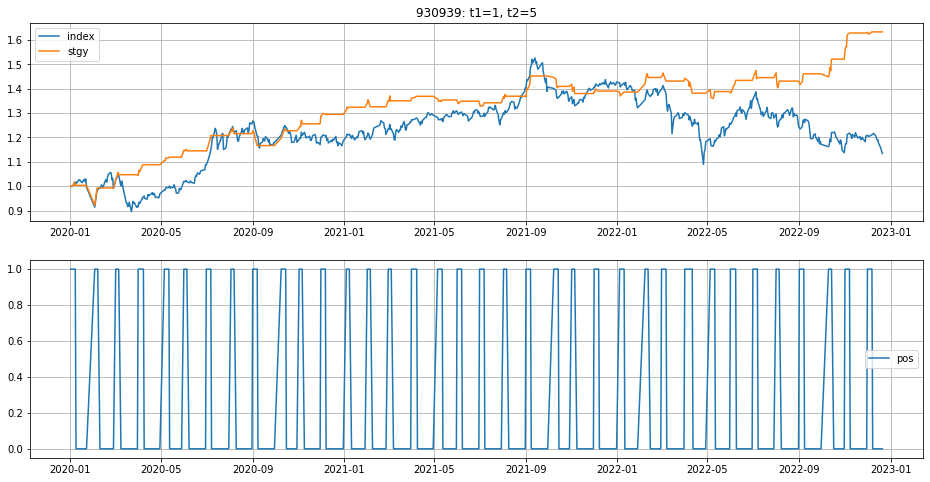

In [11]:
symbol_id = '930939'

index_data = load_hist_data(symbol_id, col_mappings={'close': symbol_id}, folder='../res/500')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

鹏扬中证500质量成长ETF

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index -0.088457  0.209337 -0.422557 -0.267433 -0.330762 -0.115265
stgy   0.174954  0.102174   1.71231 -0.069428   2.51994  0.237626


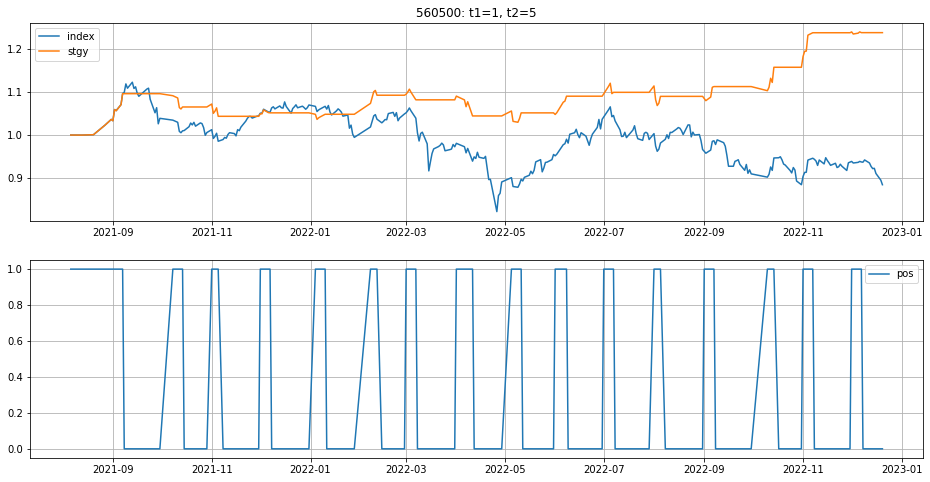

In [12]:
symbol_id = '560500'

index_data = load_hist_data(symbol_id, col_mappings={'close': symbol_id}, folder='../res/500')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

### 基金 - 景顺长城中证500行业中性低波动指数 500SNLV

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.093026  0.176677   0.52653 -0.240994  0.386007  0.302487
stgy   0.150024  0.094194  1.592721 -0.088156  1.701811  0.514834


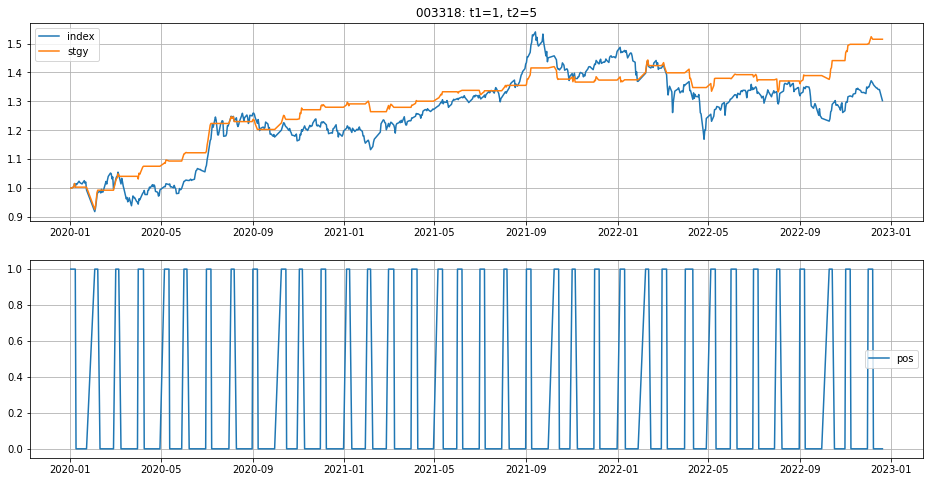

In [13]:
symbol_id = '003318'

index_data = load_hist_data(symbol_id, col_mappings={'nav': symbol_id}, folder='../res/500')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_fund)

## 红利低波 100

### 指数

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.068385  0.165778  0.412507 -0.152434  0.448616  0.217837
stgy   0.163356  0.098018   1.66659 -0.094128  1.735463  0.569567


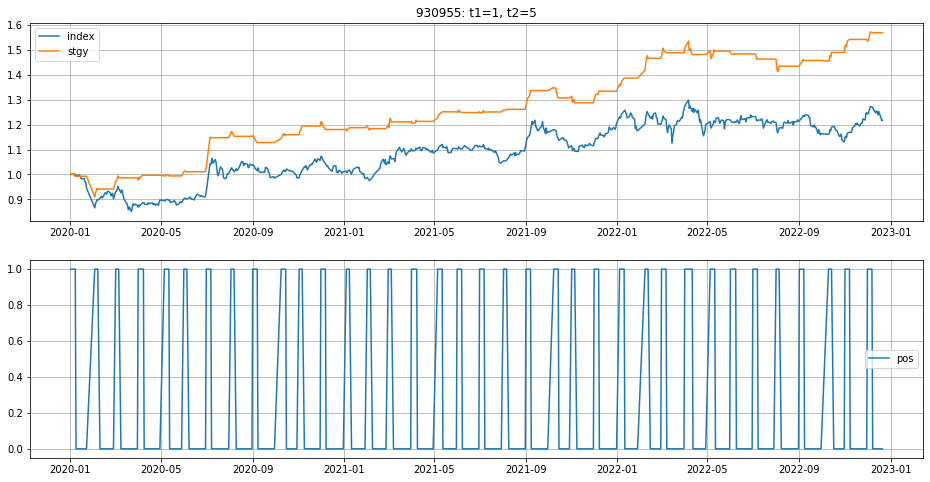

In [14]:
symbol_id = '930955'

index_data = load_hist_data(symbol_id, col_mappings={'acc_close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

### ETF

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.187494  0.156192  1.200407 -0.128622  1.457717  0.538846
stgy   0.200116  0.085502  2.340493 -0.076923  2.601501  0.580202


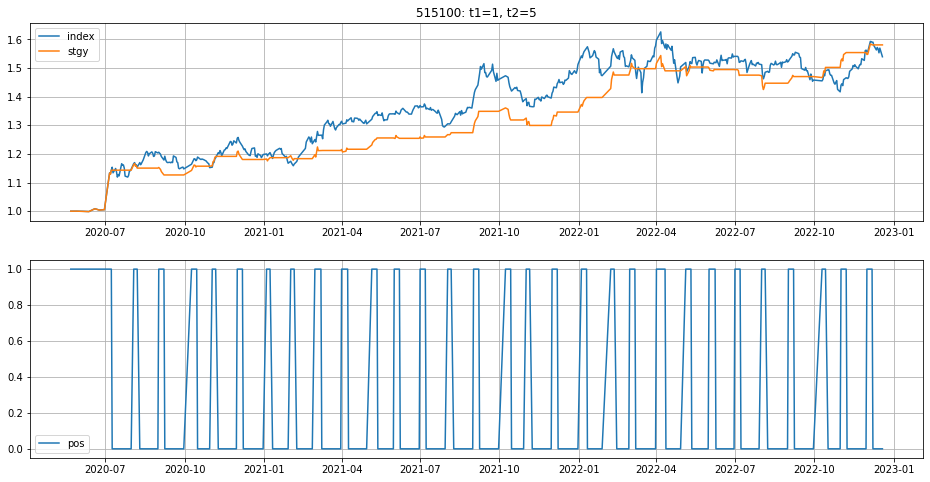

In [15]:
symbol_id = '515100'

index_data = load_hist_data(symbol_id, col_mappings={'close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

## 红利指数

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.048686   0.19127  0.254539 -0.198639  0.245095  0.151924
stgy   0.142387  0.104118  1.367564 -0.093296  1.526187  0.485959


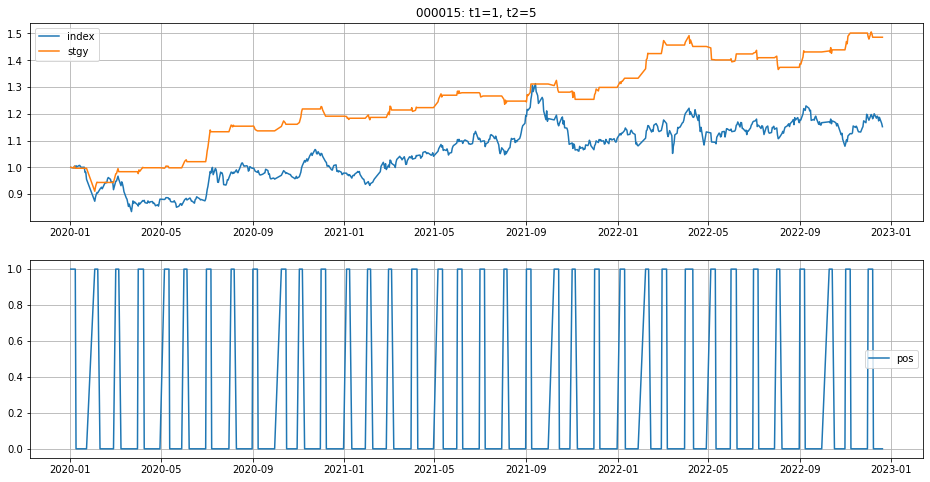

In [16]:
symbol_id = '000015'

index_data = load_hist_data(symbol_id, col_mappings={'acc_close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

华泰柏瑞上证红利ETF

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.028911  0.141667  0.204079 -0.156043  0.185277  0.088496
stgy   0.107594  0.077498  1.388338 -0.072512  1.483808  0.355317


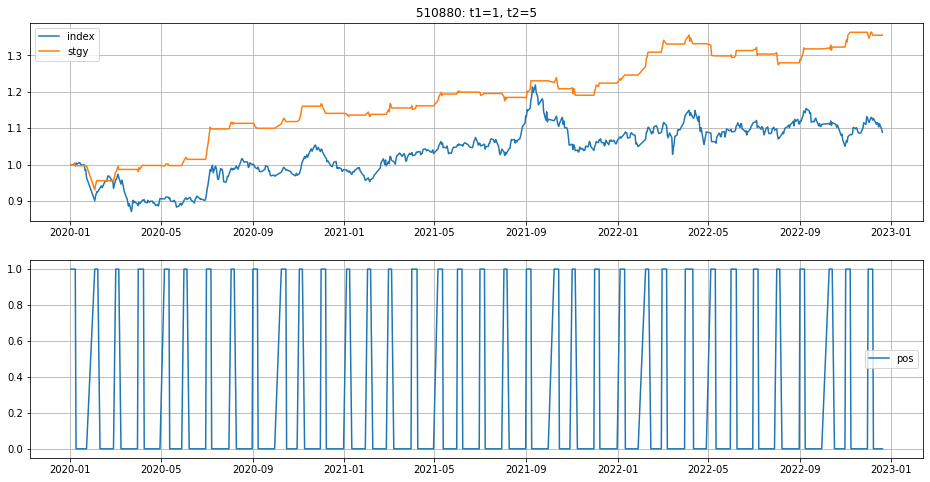

In [17]:
symbol_id = '510880'

index_data = load_hist_data(symbol_id, col_mappings={'close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

## 300 红利

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.015987  0.182649  0.087531 -0.184161  0.086813  0.048321
stgy   0.169155  0.102702  1.647043 -0.094038  1.798787  0.591963


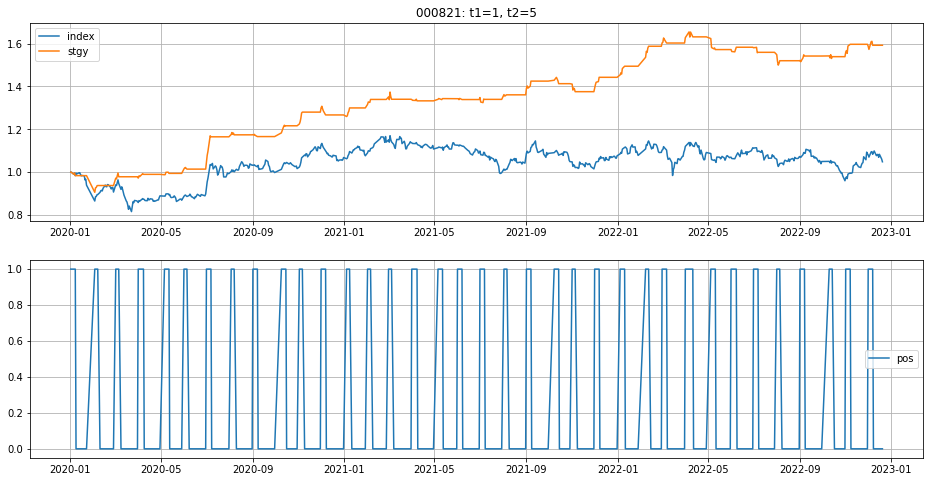

In [18]:
symbol_id = '000821'

index_data = load_hist_data(symbol_id, col_mappings={'acc_close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

建信沪深300红利ETF

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.026871  0.178716  0.150353 -0.180176  0.149135  0.082085
stgy   0.167869  0.100885  1.663963 -0.093348  1.798311  0.586762


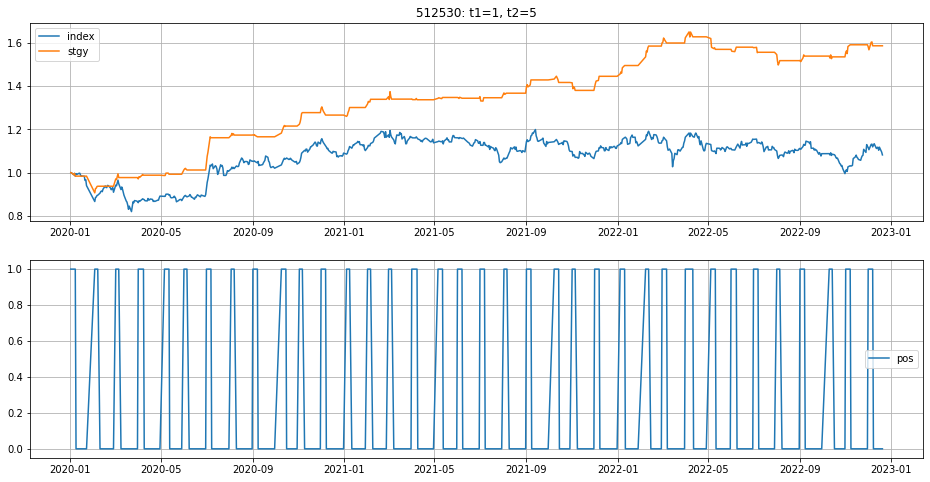

In [19]:
symbol_id = '512530'

index_data = load_hist_data(symbol_id, col_mappings={'close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

## 国企红利

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.072605  0.195209  0.371936 -0.189369  0.383406  0.231871
stgy    0.16865   0.10797  1.562004 -0.101356  1.663943  0.589920


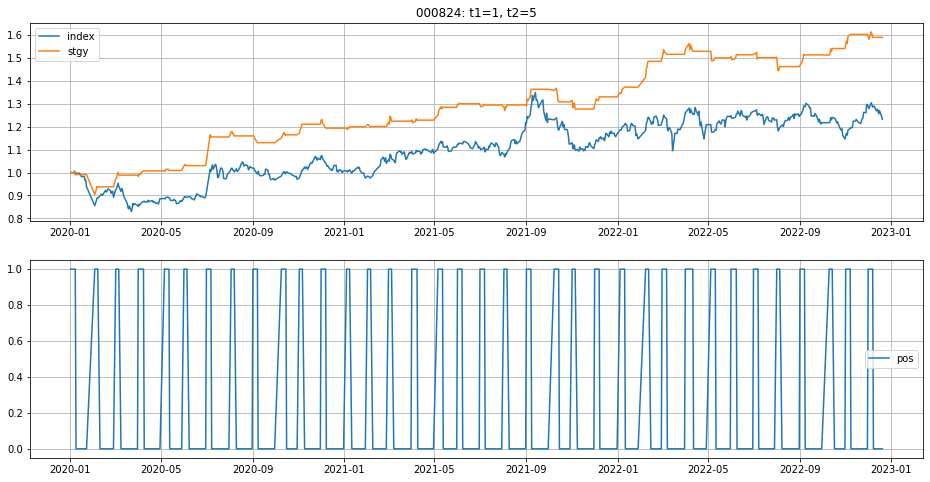

In [20]:
symbol_id = '000824'

index_data = load_hist_data(symbol_id, col_mappings={'acc_close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

LOF

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.157868  0.197538  0.799177 -0.192785  0.818884  0.546675
stgy   0.189145  0.110269  1.715305 -0.086594   2.18428  0.674323


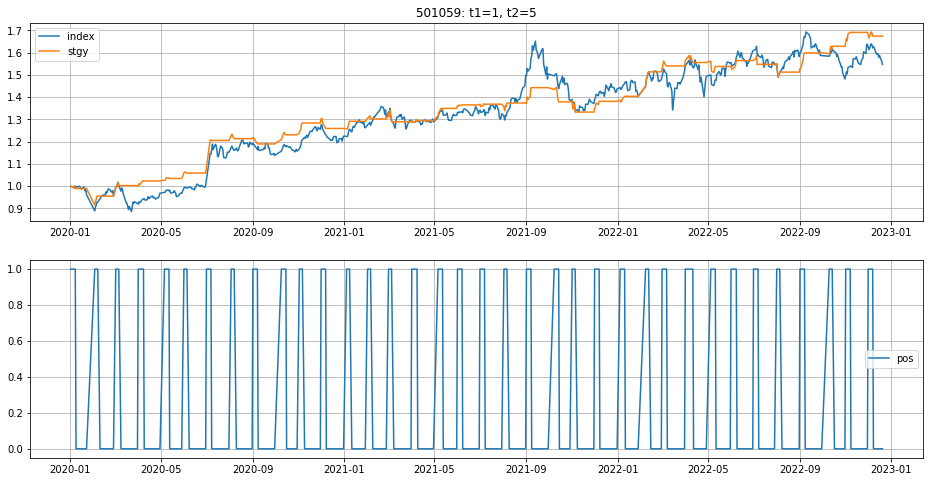

In [21]:
symbol_id = '501059'

index_data = load_hist_data(symbol_id, col_mappings={'close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

## 中证红利

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.079912  0.190052  0.420474 -0.183898  0.434546  0.257006
stgy   0.164952  0.102285  1.612665 -0.099954  1.650285  0.574998


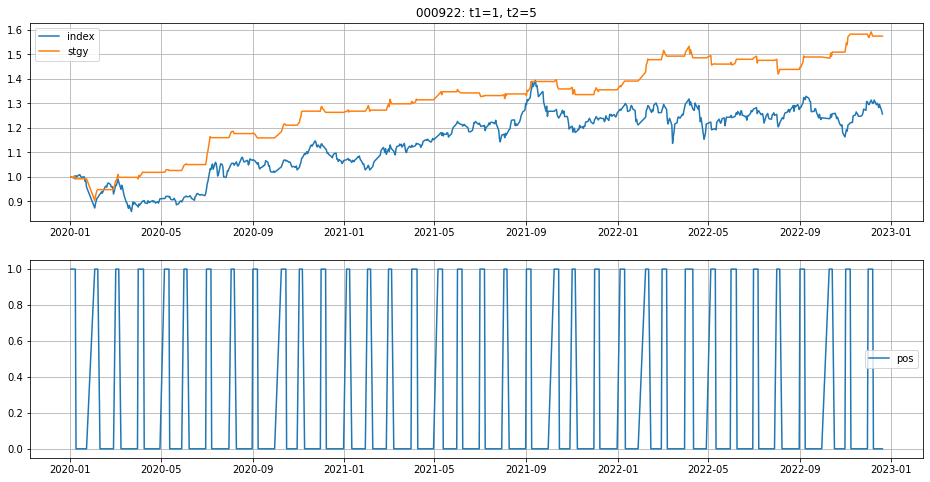

In [22]:
symbol_id = '000922'

index_data = load_hist_data(symbol_id, col_mappings={'acc_close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

招商中证红利ETF

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.134835  0.178331  0.756092 -0.169142   0.79717  0.456920
stgy   0.168602   0.09682  1.741396 -0.095356  1.768135  0.589724


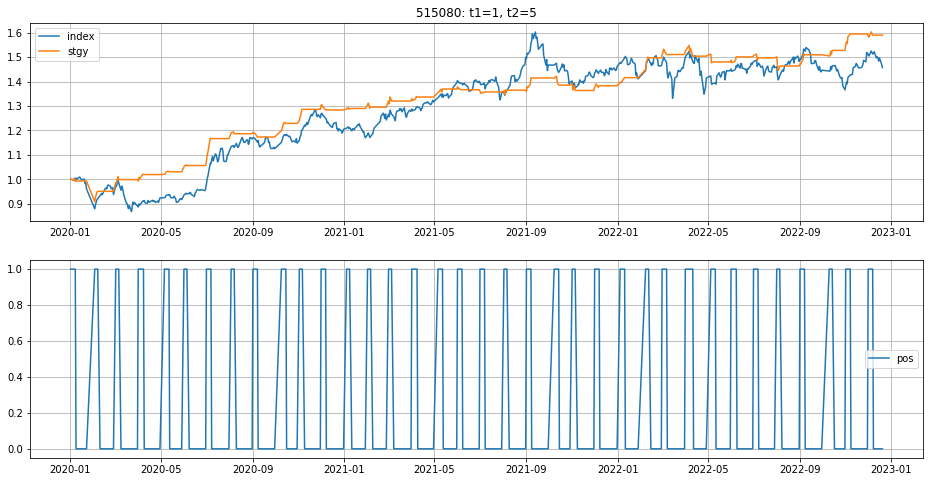

In [23]:
symbol_id = '515080'

index_data = load_hist_data(symbol_id, col_mappings={'close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

易方达中证红利ETF

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.097252  0.180247   0.53955 -0.175464  0.554258  0.318015
stgy   0.161057  0.097582  1.650469 -0.096529  1.668481  0.559382


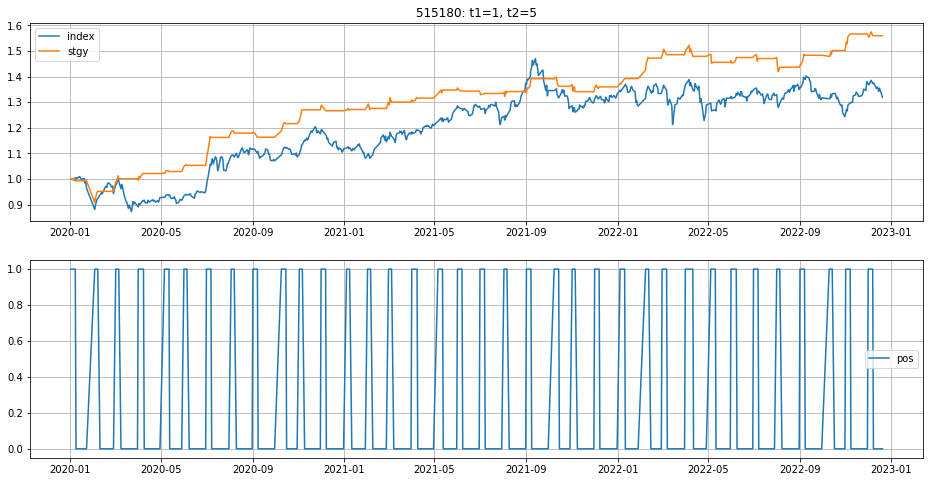

In [24]:
symbol_id = '515180'

index_data = load_hist_data(symbol_id, col_mappings={'close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

## 红利潜力

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.040389  0.214777  0.188053 -0.331001  0.122022  0.125023
stgy   0.205592  0.112423  1.828725 -0.106567  1.929223  0.744164


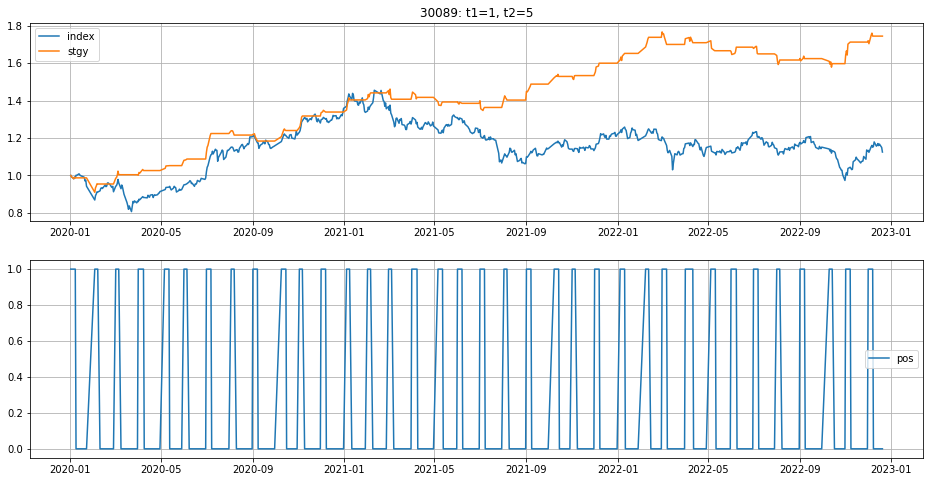

In [25]:
symbol_id = '30089'

index_data = load_hist_data(symbol_id, col_mappings={'acc_close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

基金

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.063823  0.200545  0.318246 -0.312593  0.204172  0.202102
stgy   0.182205  0.105051  1.734432 -0.107074  1.701673  0.645416


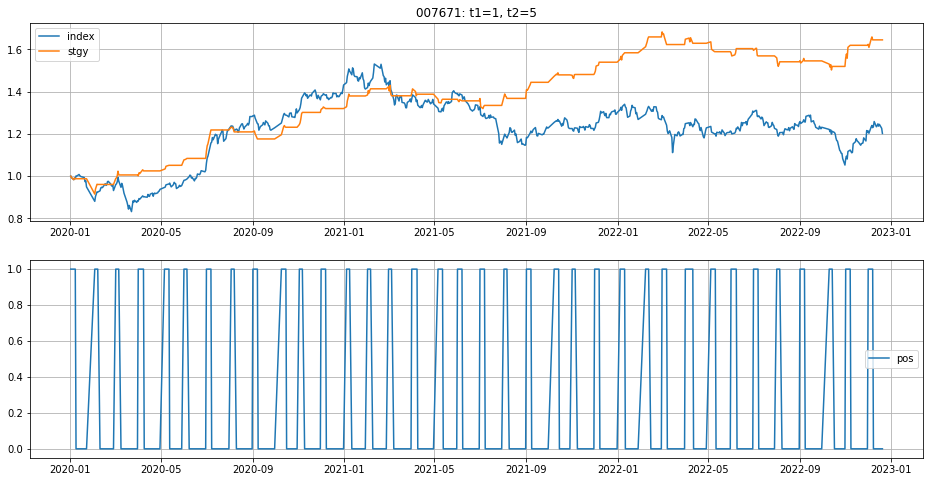

In [26]:
symbol_id = '007671'

index_data = load_hist_data(symbol_id, col_mappings={'nav': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_fund)

## 消费红利

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.159475  0.242819  0.656765  -0.19623  0.812693  0.553069
stgy   0.243816  0.128659   1.89506 -0.097102  2.510931  0.913898


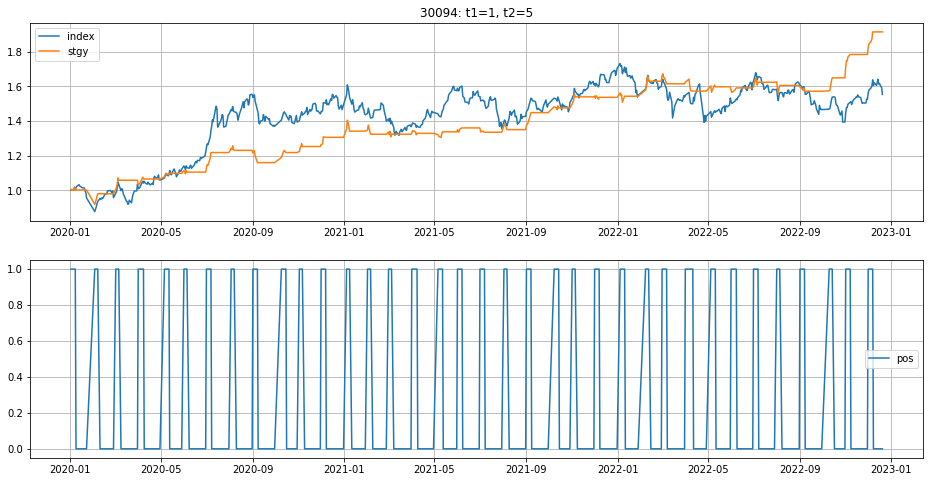

In [27]:
symbol_id = '30094'

index_data = load_hist_data(symbol_id, col_mappings={'acc_close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

泰达消费红利指数A

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.232464  0.216842  1.072044 -0.181306  1.282161  0.759200
stgy   0.224121  0.109187   2.05264 -0.071742  3.123975  0.727204


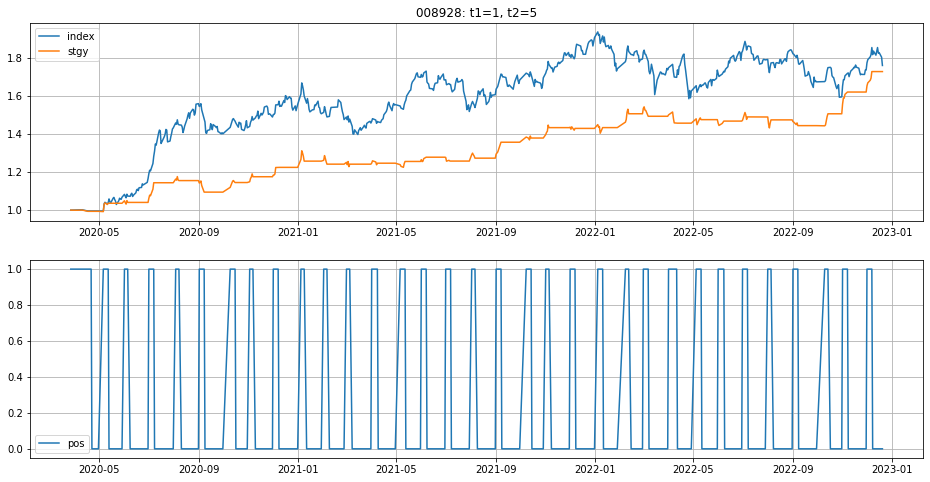

In [28]:
symbol_id = '008928'

index_data = load_hist_data(symbol_id, col_mappings={'nav': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_fund)

## 深证红利

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index -0.025235  0.239501 -0.105367   -0.4987 -0.050602 -0.073225
stgy   0.203632  0.130261  1.563267 -0.162889  1.250127  0.735745


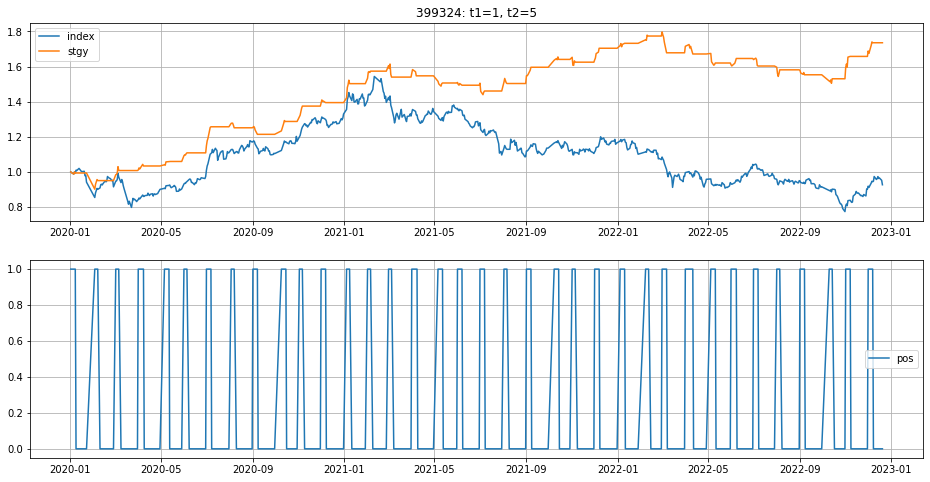

In [29]:
symbol_id = '399324'

index_data = load_hist_data(symbol_id, col_mappings={'acc_close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

ETF

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index -0.031653  0.236976 -0.133572 -0.500707 -0.063217 -0.091261
stgy   0.199769  0.129292  1.545101 -0.161496  1.236988  0.719220


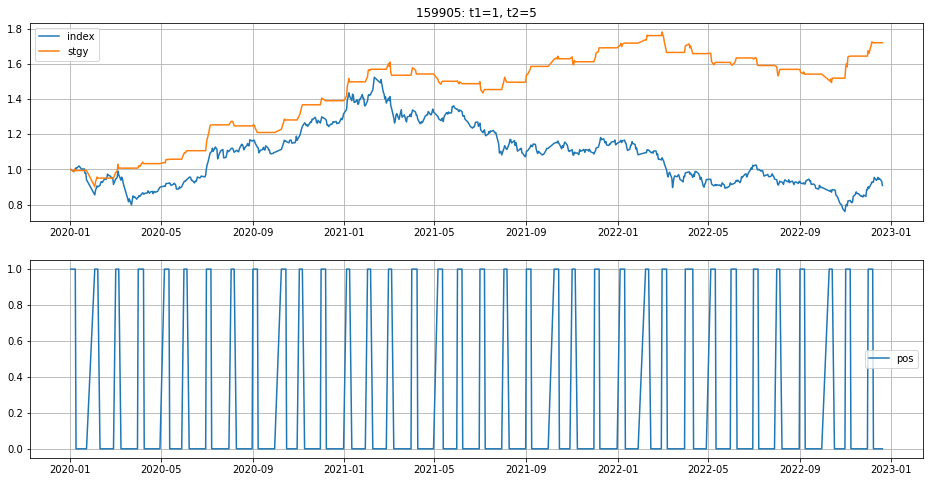

In [30]:
symbol_id = '159905'

index_data = load_hist_data(symbol_id, col_mappings={'close': symbol_id}, folder='../res/div')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

## 医疗

医药100

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index   0.03415  0.163281  0.209149 -0.266993  0.127906  0.105222
stgy   0.076893   0.08166  0.941622 -0.105843   0.72648  0.246961


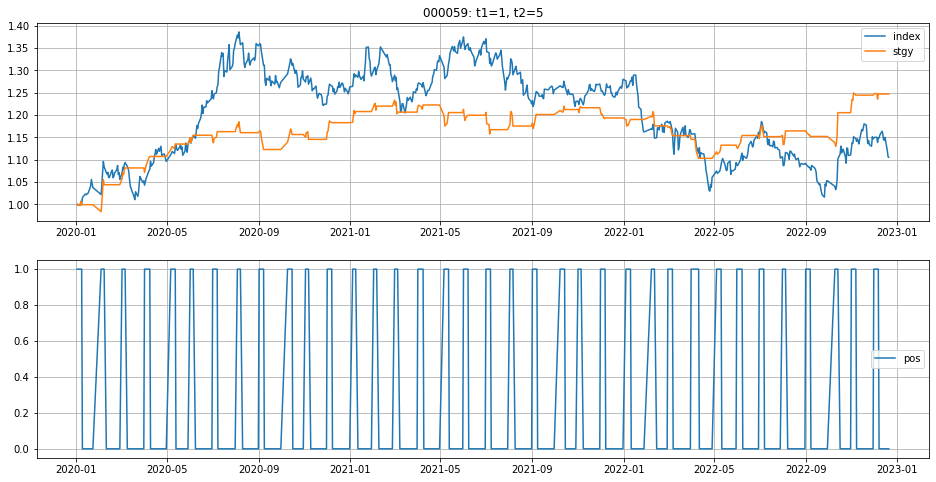

In [34]:
symbol_id = '000059'

index_data = load_hist_data(symbol_id, col_mappings={'nav': symbol_id}, folder='../res/medicine')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)

300医药

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index -0.014037   0.29156 -0.048146 -0.531021 -0.026435 -0.041244
stgy   0.084373  0.152426  0.553539 -0.297845   0.28328  0.272945


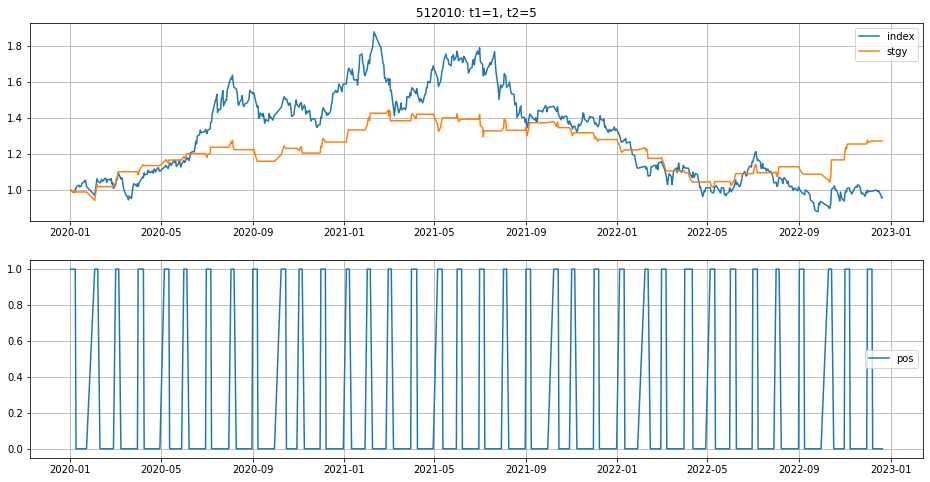

In [33]:
symbol_id = '512010'

index_data = load_hist_data(symbol_id, col_mappings={'close': symbol_id}, folder='../res/medicine')
calendar_strategy(index_data, symbol_id, start_date, end_date, day_range, fee_rate_stock)